# Supervised Machine Learning: Regression problem

## Business Context

**EnergyCo** is a leading utility company that provides electricity to millions of households. In the era of smart technologies and increasing emphasis on energy sustainability, accurate forecasting of household energy consumption has become paramount. EnergyCo aims to enhance its services and operational efficiency by implementing a **Smart Energy Management System (SEMS)**. A core component of SEMS is the ability to **forecast individual household energy consumption** accurately.

## Problem Statement

EnergyCo seeks to predict each household's energy consumption to optimize its Smart Energy Management System. Accurate energy consumption forecasts will enable EnergyCo to make informed decisions in the following areas:

- **Energy Distribution:** Efficiently allocate energy resources to meet varying demand, preventing overloading and reducing energy wastage.
- **Dynamic Pricing Models:** Implement pricing strategies that reflect real-time energy demand, encouraging energy conservation during peak hours.
- **Customer Engagement Strategies:** Provide personalized energy-saving recommendations to households based on their usage patterns, enhancing customer satisfaction and loyalty.
- **Demand Response Programs:** Initiate programs that adjust energy usage during high-demand periods, ensuring grid stability and reliability.

## Objective

- **Type of Task:** Regression
- **Goal:** Develop a predictive model to forecast the active energy consumed every minute (in kilowatt) in the household

## Success Criteria

To evaluate the effectiveness of the energy consumption forecasting model, the following success criteria and evaluation metrics will be employed:

### Evaluation Metrics

1. **Mean Absolute Error (MAE):** Measures the average magnitude of errors in the predictions without considering their direction. Lower MAE indicates higher accuracy.
   
2. **Mean Squared Error (MSE):** Measures the average of the squares of the errors, penalizing larger errors more severely than MAE.
   
3. **Root Mean Squared Error (RMSE):** Provides the square root of MSE, giving an error magnitude in the same units as the target variable. Lower RMSE signifies better model performance.
   
4. **R² Score (Coefficient of Determination):** Indicates the proportion of variance in the target variable that is predictable from the feature variables. An R² score closer to 1 denotes a model that explains a large portion of the variance.

### Performance Goals

- **RMSE:** Aim to achieve the lowest possible RMSE to ensure high predictive accuracy of the model.
  
- **R² Score:** Strive for an R² score as close to 1 as possible, indicating that the model effectively captures the variability in energy consumption data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scripts import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import os
import joblib


In [2]:
# Load dataset
file_path = "./datasets/household_power_consumption.csv"
nrows = 500000
dataset = pd.read_csv(file_path, low_memory=False, nrows=nrows)
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data Exploration and Preparation

## Data Cleaning

#### A. Handle Missing Values

In [3]:
# identify missing values
missing_values = dataset.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           3933
dtype: int64


In [4]:
# remove columns containing missing values
dataset = dataset.dropna()

print(f"Dataset Shape After Dropping Rows with Any Missing Values: {dataset.shape}")

print("Missing Values After Dropping Rows:\n", dataset.isnull().sum())

Dataset Shape After Dropping Rows with Any Missing Values: (496067, 9)
Missing Values After Dropping Rows:
 Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


#### B. Correct Data Types

In [5]:
# Convert 'Date' and 'Time' to datetime
dataset['DateTime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop the original 'Date' and 'Time' columns if no longer needed
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

In [6]:
# Convert numerical columns to float
numerical_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
dataset[numerical_cols] = dataset[numerical_cols].astype(float)
dataset.dtypes

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
DateTime                 datetime64[ns]
dtype: object

#### C. Remove Duplicates

In [7]:
# Check for duplicates
duplicate_count = dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates if any
dataset.drop_duplicates(inplace=True)

Number of duplicate rows: 0


#### D. Address Outliers and Inconsistencies

##### Identify outliers using box plots

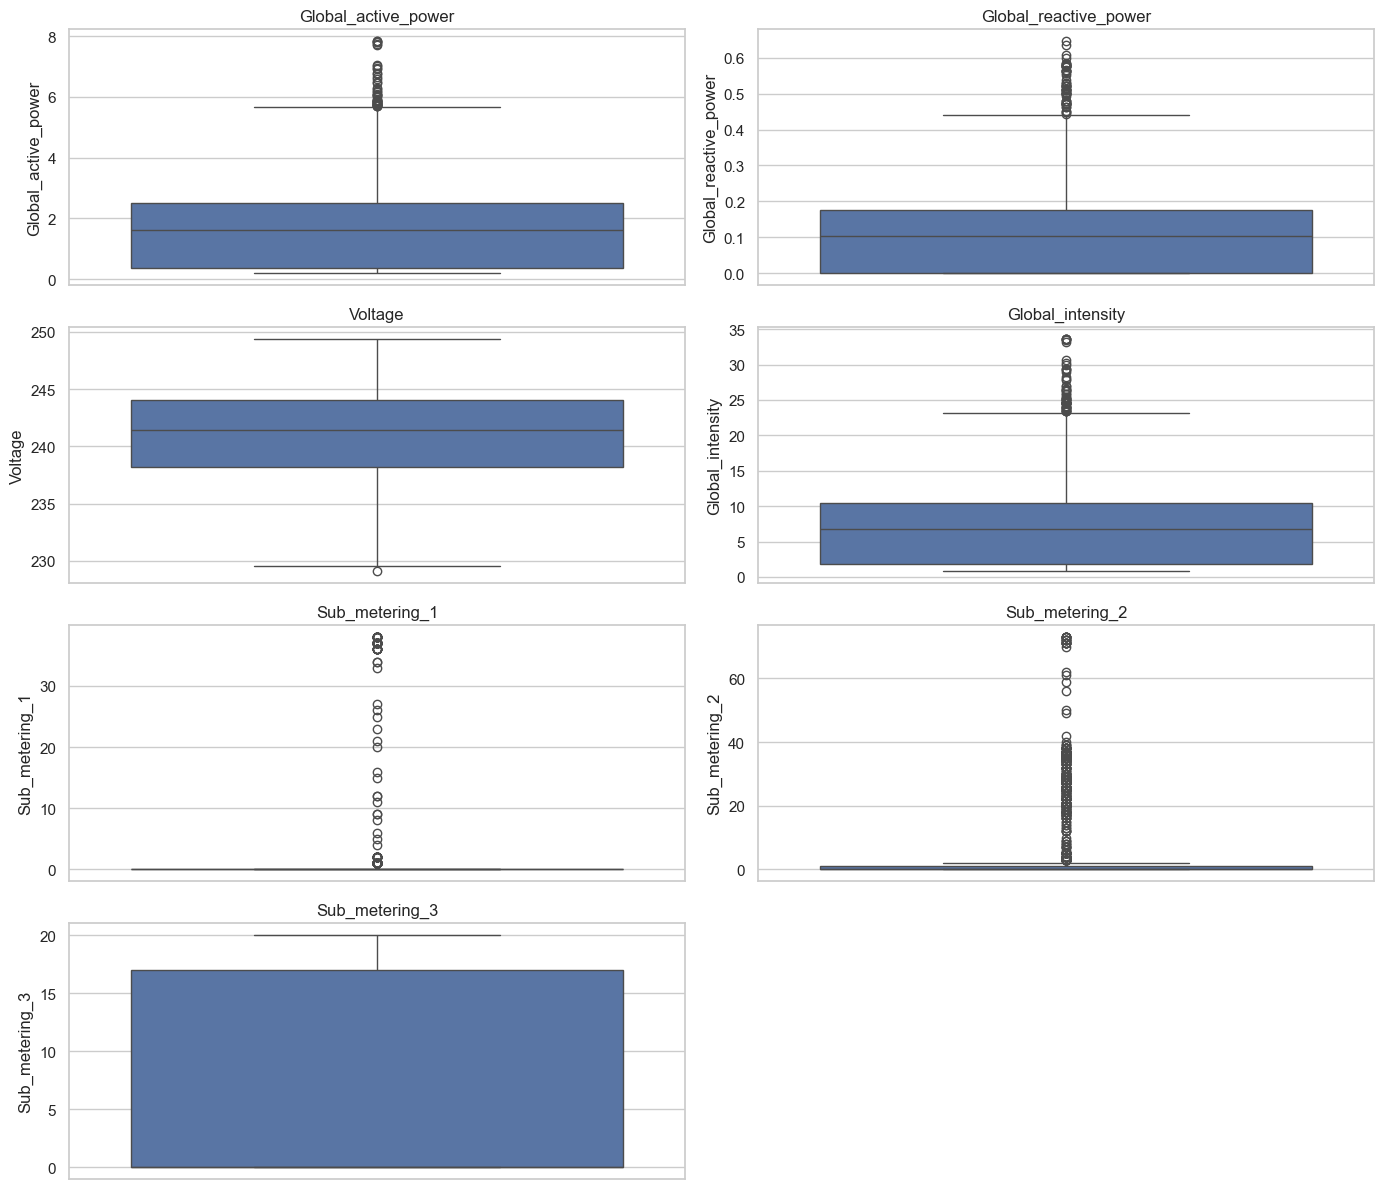

In [8]:
# identify outliers using box plots
plot_boxplots(df=dataset.iloc[:5000], columns=numerical_cols, titles=numerical_cols)

##### Handle outliers by appyling Capping (Winsorizing)

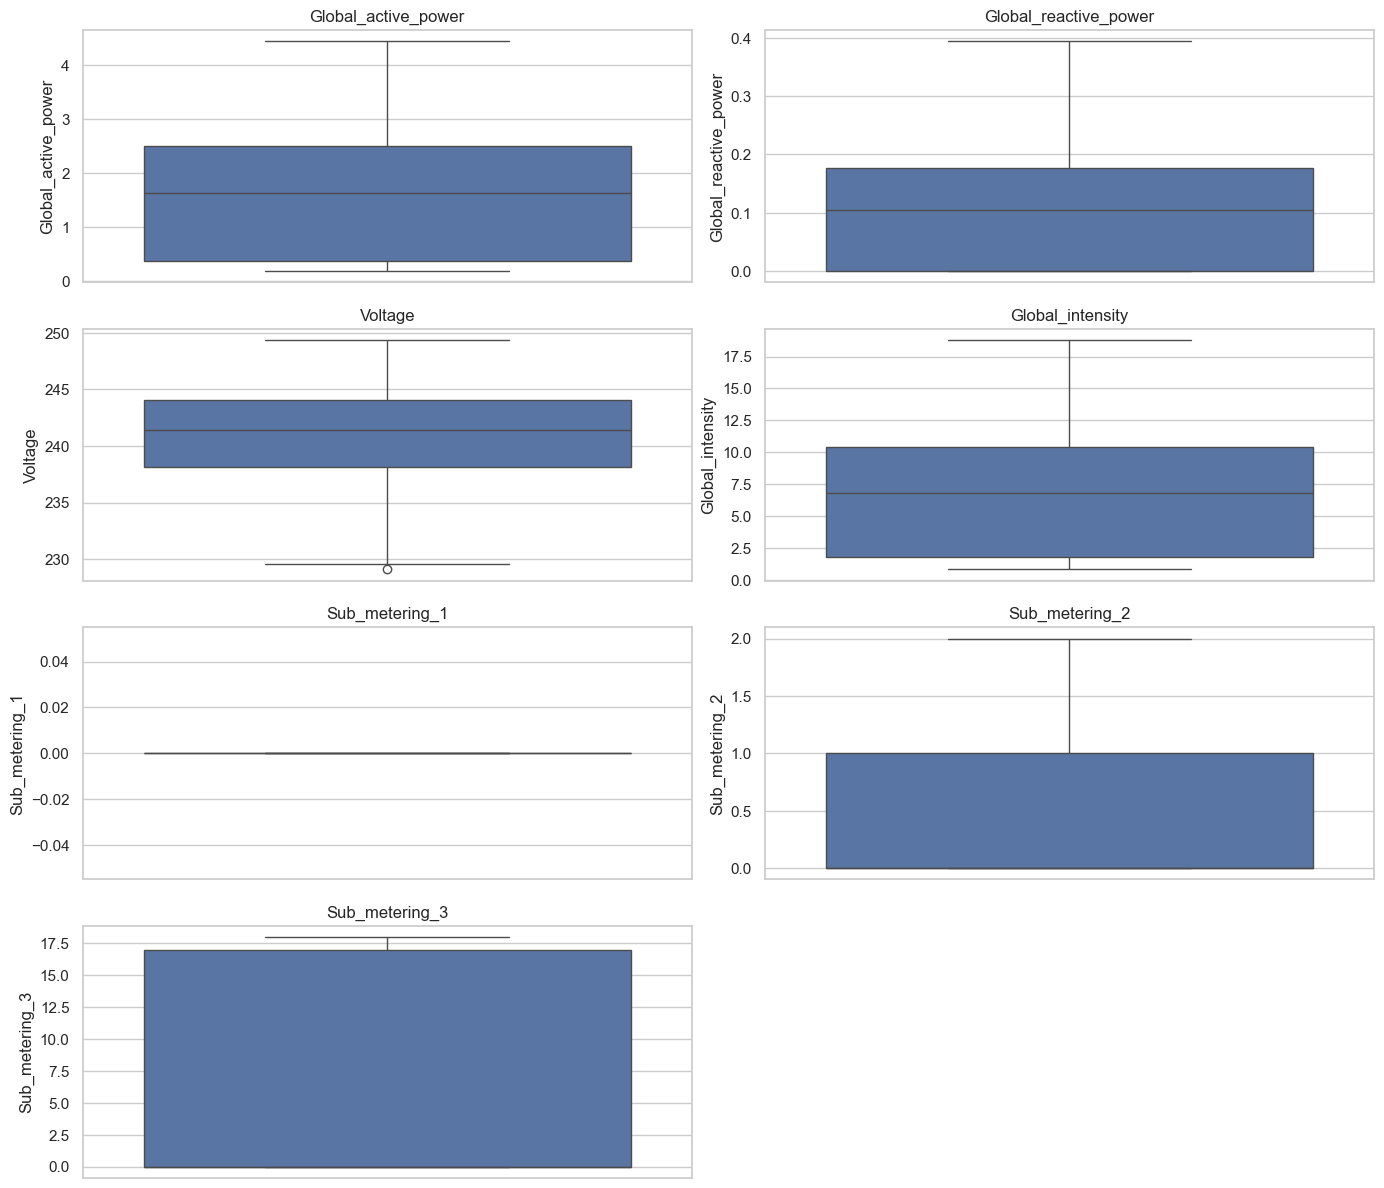

In [9]:
numerical_cols_outliers = numerical_cols.copy()
sub_metering_outliers = ["Sub_metering_1", "Sub_metering_2"]

# remove voltage feature as it doesn't containt outliers
numerical_cols_outliers.remove("Voltage")

numerical_cols_outliers.remove("Sub_metering_1")
numerical_cols_outliers.remove("Sub_metering_2")

cap_outliers(dataset, numerical_cols_outliers, 2, 98)

# Handle sub metering 1 and 2 features separately
cap_outliers(dataset, sub_metering_outliers, 10, 90)

# Verify the changes using Boxplot after capping outliers
plot_boxplots(df=dataset.iloc[:5000], columns=numerical_cols, titles=numerical_cols)

## Exploratory Data Analysis

In [10]:
# Display basic statistics for Global Active Power
global_active_power_stats = dataset['Global_active_power'].describe()
print("Descriptive Statistics for Global Active Power:")
print(global_active_power_stats)

Descriptive Statistics for Global Active Power:
count    496067.000000
mean          1.085675
std           1.086876
min           0.112000
25%           0.274000
50%           0.482000
75%           1.536000
max           4.430000
Name: Global_active_power, dtype: float64


In [11]:
# Convert 'datetime' to datetime type and set as index
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])
dataset.set_index('DateTime', inplace=True)

# drop sub metering 1 as most of the data is 0
dataset.drop(columns=["Sub_metering_1"], inplace=True)
numerical_cols.remove("Sub_metering_1")


### Univariate Analysis

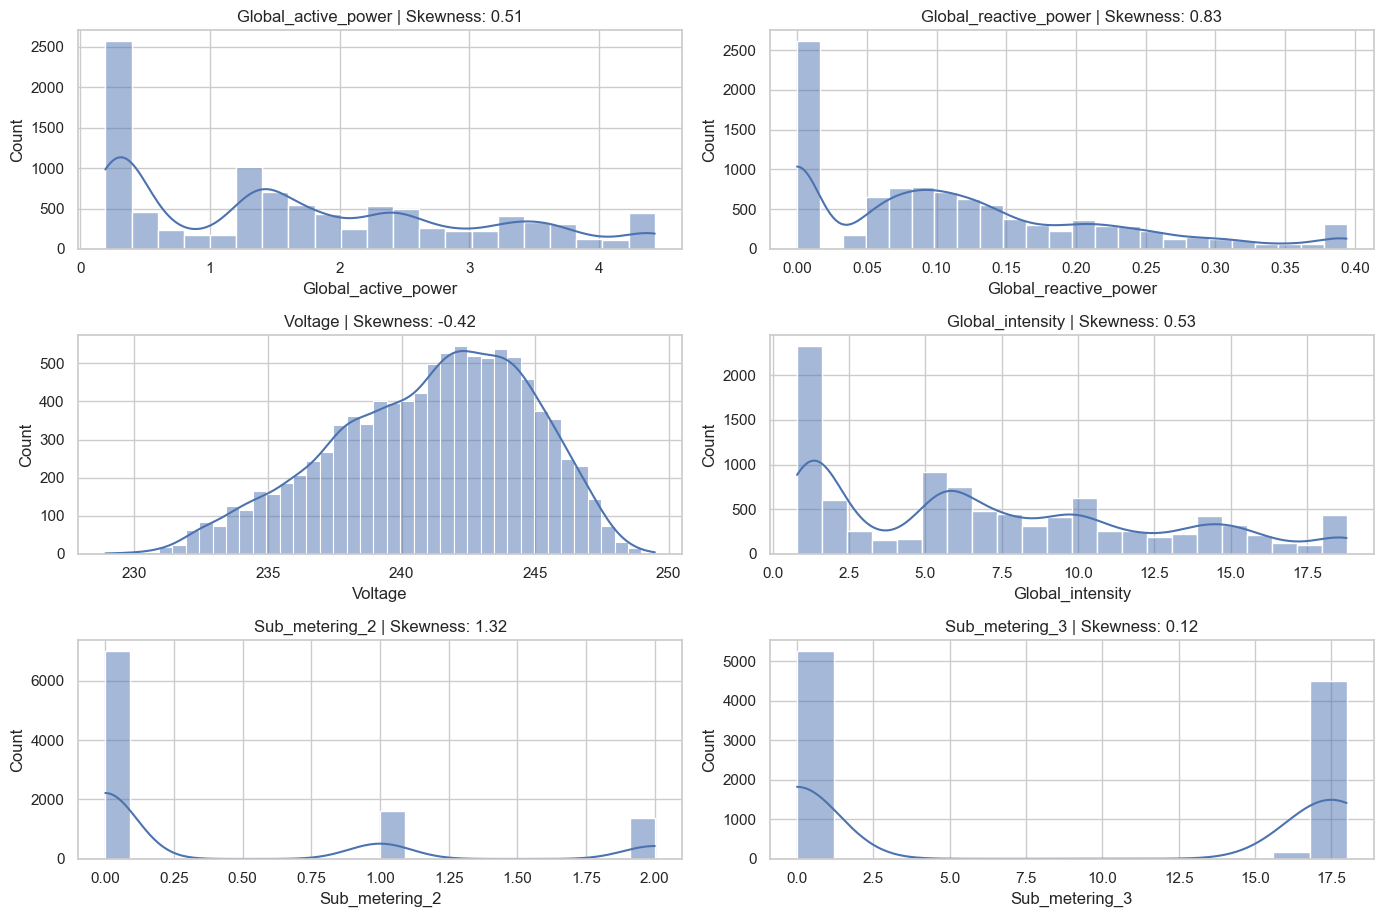

In [12]:
# Plot Histogram with density plot distribution for each numerical feature
plot_histplots(df=dataset.iloc[:10000], columns=numerical_cols, titles=numerical_cols)

### Time Series Analysis

#### Energy consumption data on a Daily frequency basis

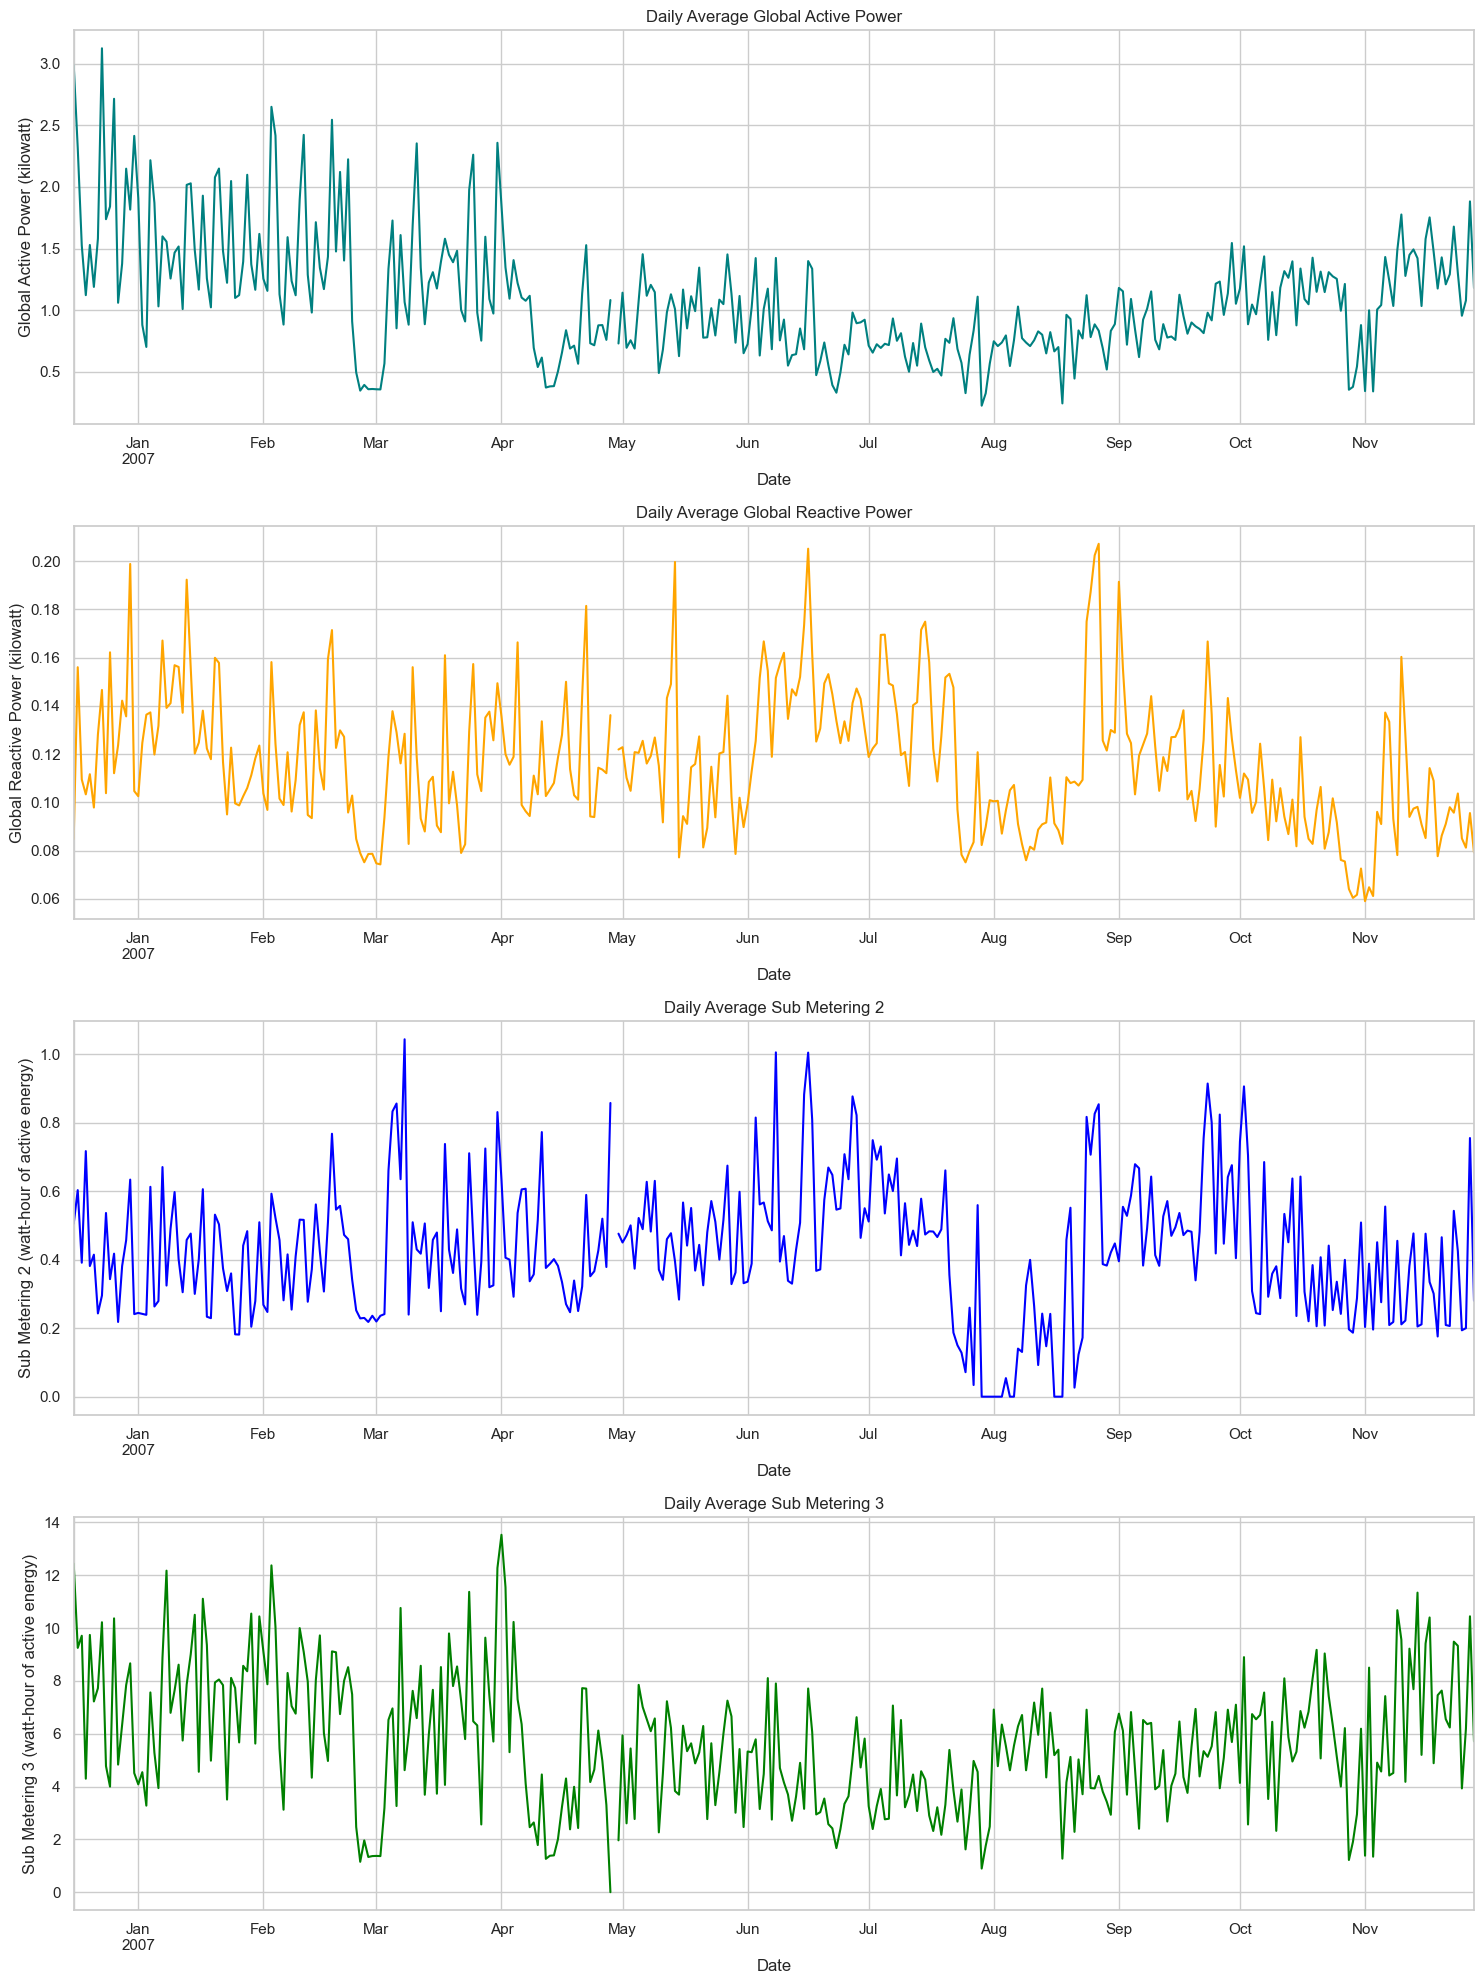

In [13]:
columns_to_plot = [
    "Global_active_power",
    "Global_reactive_power",
    "Sub_metering_2",
    "Sub_metering_3",
]

# Resampling to Daily Frequency
daily_data = dataset.resample("D").mean()

# Plotting daily aggregated data
plt.figure(figsize=(15, 20))

colors = ["teal", "orange", "blue", "green"]
daily_titles = [
    "Daily Average Global Active Power",
    "Daily Average Global Reactive Power",
    "Daily Average Sub Metering 2",
    "Daily Average Sub Metering 3",
]
y_labels = [
    "Global Active Power (kilowatt)",
    "Global Reactive Power (kilowatt)",
    "Sub Metering 2 (watt-hour of active energy)",
    "Sub Metering 3 (watt-hour of active energy)",
]

for i, (col, color, title, ylabel) in enumerate(
    zip(columns_to_plot, colors, daily_titles, y_labels), 1
):
    plt.subplot(len(columns_to_plot), 1, i)
    daily_data[col].plot(color=color)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)

plt.tight_layout()
plt.show()


##### Analysis of Daily Energy Consumption Patterns

1. **Global Active Power (Daily):**
   - **High Consumption Days:** Peaks observed in December-February(Winter season), reaching up to 3.0 kilowatts
   - **Low Consumption Days:** Lowest usage in July-August, dropping to 0.5-1.0 kilowatts
   - **Average Consumption:** Typically ranges between 1.5-2.0 kilowatts during spring/fall

2. **Global Reactive Power (Daily):**
   - **Peak Usage:** Spikes of 0.20 kilowatts observed in September and January
   - **Low Usage:** Minimum values of 0.06-0.08 kilowatts in summer months
   - **Daily Fluctuations:** More volatile during winter months
   - **Stable Periods:** Most stable readings during May-June

3. **Sub Metering 1 (Daily):**
   - **Overall Pattern:** Extremely stable consumption around 0.00 watt-hours
   - **Variations:** Minimal daily fluctuations throughout the year
   - **Seasonal Impact:** No significant seasonal variations observed

4. **Sub Metering 2 (Daily):**
   - **High Usage Days:** Peaks of 1.0 watt-hours in March and June
   - **Low Usage Period:** August shows minimal consumption (0.0-0.2 watt-hours)
   - **Average Usage:** Typically 0.4-0.6 watt-hours during normal days
   - **Pattern:** More variable consumption during winter months

5. **Sub Metering 3 (Daily):**
   - **Peak Consumption:** Reaches 12-14 watt-hours during winter days
   - **Low Consumption:** Drops to 2-4 watt-hours during summer
   - **Daily Variations:** Most volatile among all sub-meters
   - **Seasonal Impact:** Strong seasonal pattern with winter peaks

#### Energy consumption data on a monthly frequency basis 

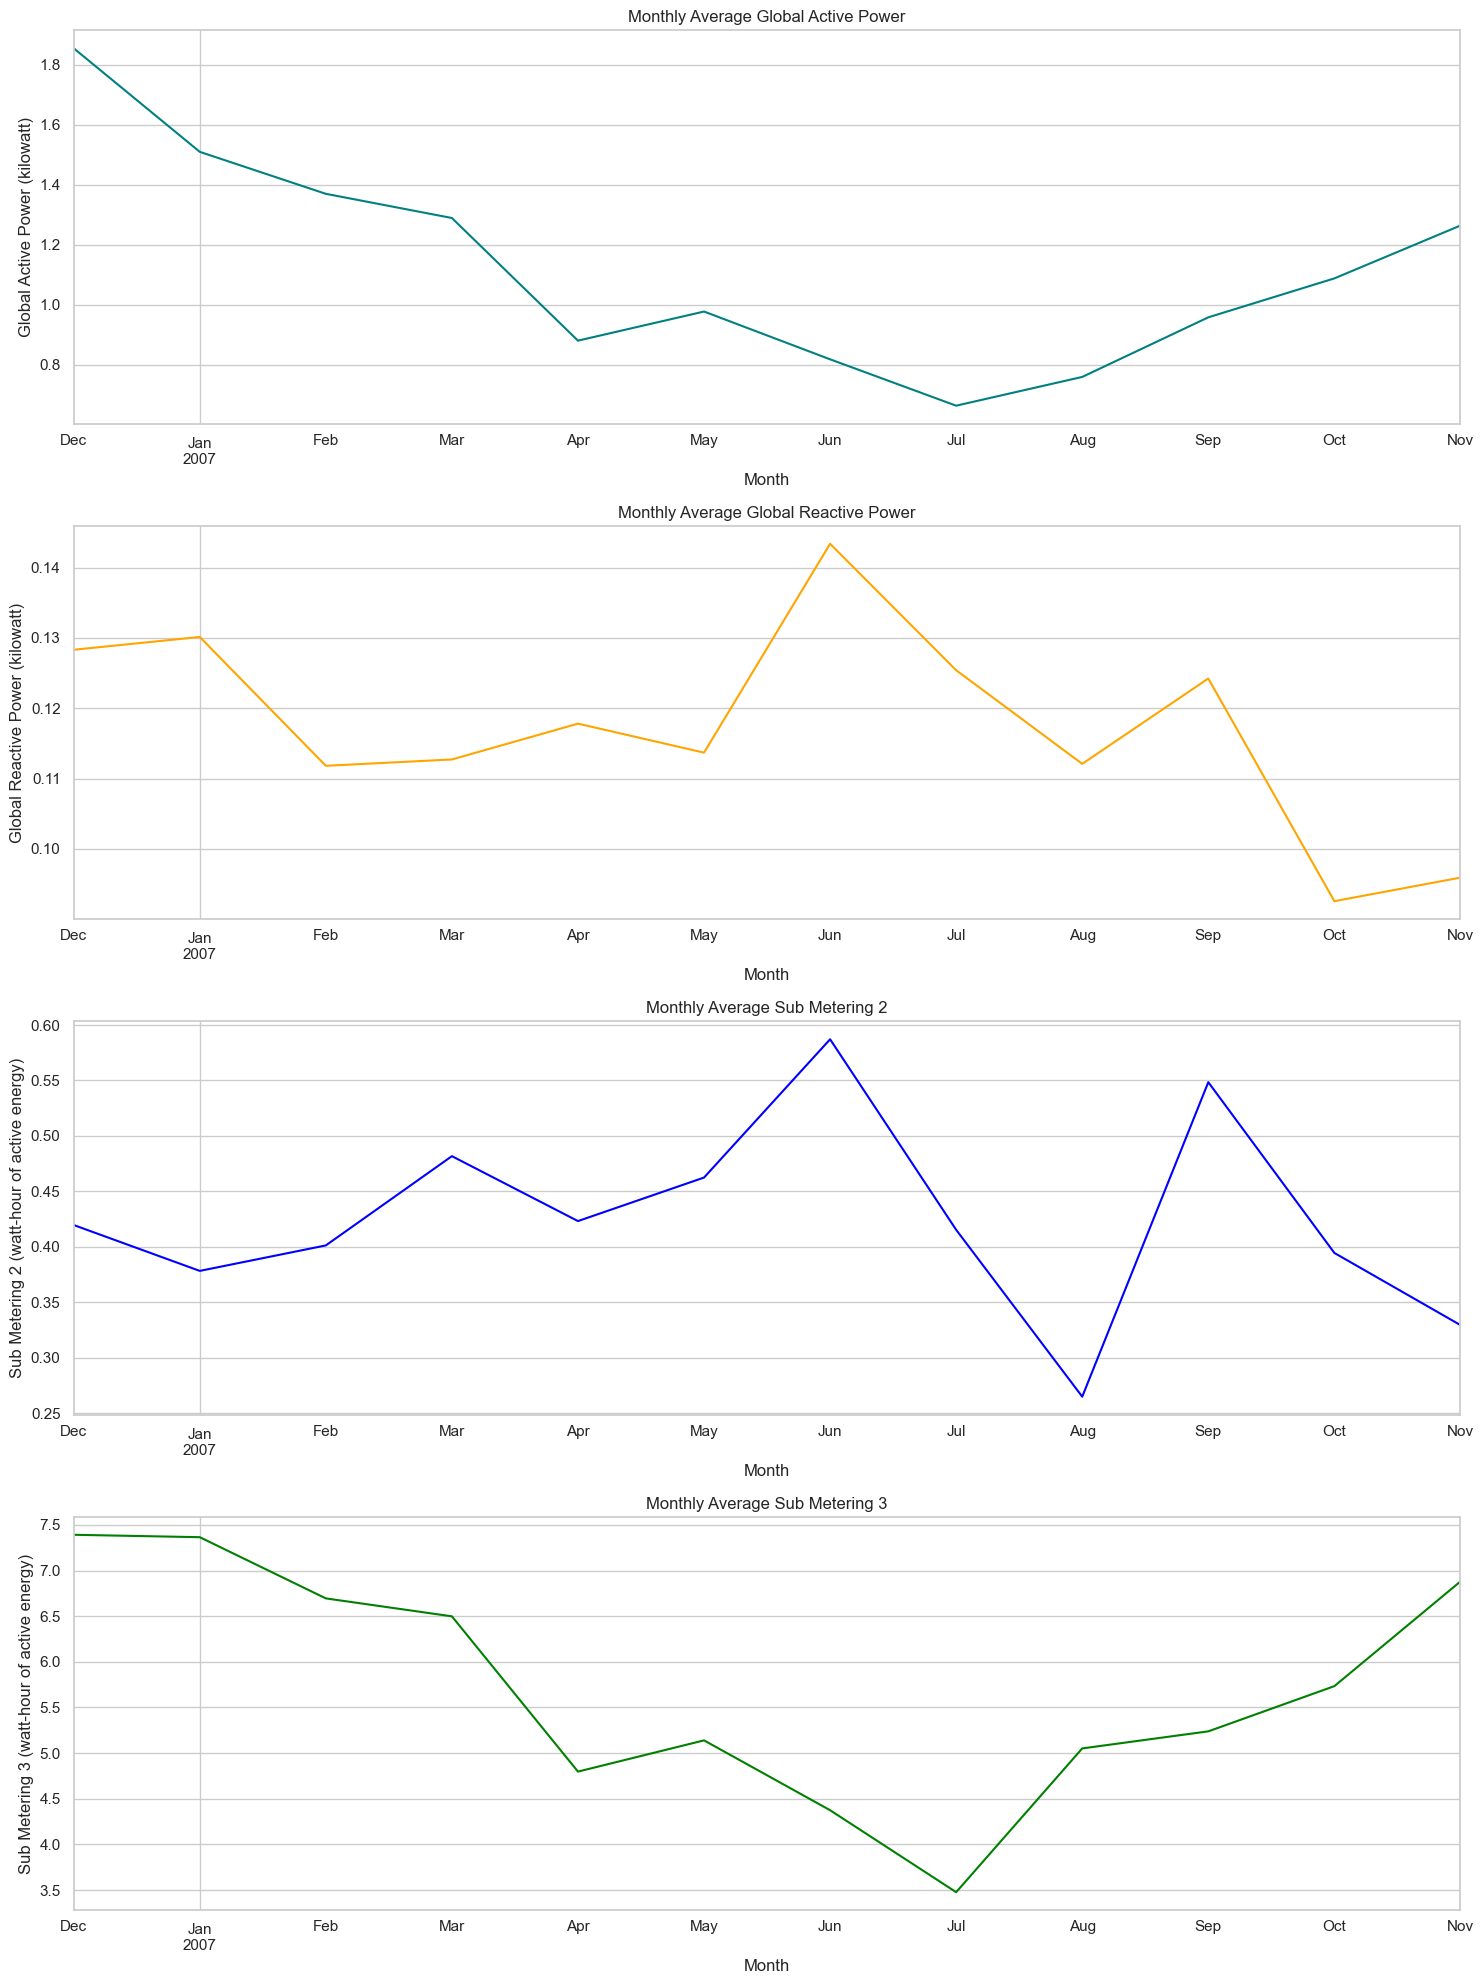

In [14]:
# Resample to monthly frequency and compute mean
monthly_data = dataset.resample("ME").mean()

monthly_titles = [
    "Monthly Average Global Active Power",
    "Monthly Average Global Reactive Power",
    "Monthly Average Sub Metering 2",
    "Monthly Average Sub Metering 3",
]

# Plotting monthly aggregated data in a single figure with subplots
plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

for i, (col, color, title, ylabel) in enumerate(
    zip(columns_to_plot, colors, monthly_titles, y_labels), 1
):
    plt.subplot(len(columns_to_plot), 1, i)
    monthly_data[col].plot(color=color)
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(ylabel)

plt.tight_layout()  
plt.show()



##### Analysis of Monthly Energy Consumption Patterns

1. **Global Active Power (Monthly):**
   - **High Consumption Months:** January (2.5-3.0 kW), February (2.0-2.5 kW)
   - **Low Consumption Months:** July-August (1.0-1.5 kW)
   - **Transition Periods:** 
     - Gradual decrease: March to June
     - Gradual increase: September to December
   - **Average Consumption:** 1.8 kW across all months

2. **Global Reactive Power (Monthly):**
   - **Peak Months:** January (0.15-0.18 kW), September (0.16-0.20 kW)
   - **Low Usage Months:** July-August (0.08-0.10 kW)
   - **Stable Periods:** April-June shows consistent consumption
   - **Monthly Trend:** Follows similar pattern to active power

3. **Sub Metering 1 (Monthly):**
   - **Consistent Pattern:** Maintains steady level near 0.00 watt-hours
   - **Monthly Variations:** Negligible changes between months
   - **Annual Trend:** No significant monthly or seasonal patterns

4. **Sub Metering 2 (Monthly):**
   - **Highest Usage:** March (0.6-0.8 watt-hours), June (0.7-0.9 watt-hours)
   - **Lowest Usage:** August (0.1-0.3 watt-hours)
   - **Average Consumption:** 0.4-0.5 watt-hours in typical months
   - **Seasonal Pattern:** Higher usage in winter and early summer

5. **Sub Metering 3 (Monthly):**
   - **Peak Months:** December-February (8-10 watt-hours)
   - **Low Consumption:** July-August (3-4 watt-hours)
   - **Transition Months:** 
     - Decreasing: March to June
     - Increasing: September to November
   - **Average Usage:** 6-7 watt-hours during moderate months

#### Energy consumption data on a weekly frequency basis

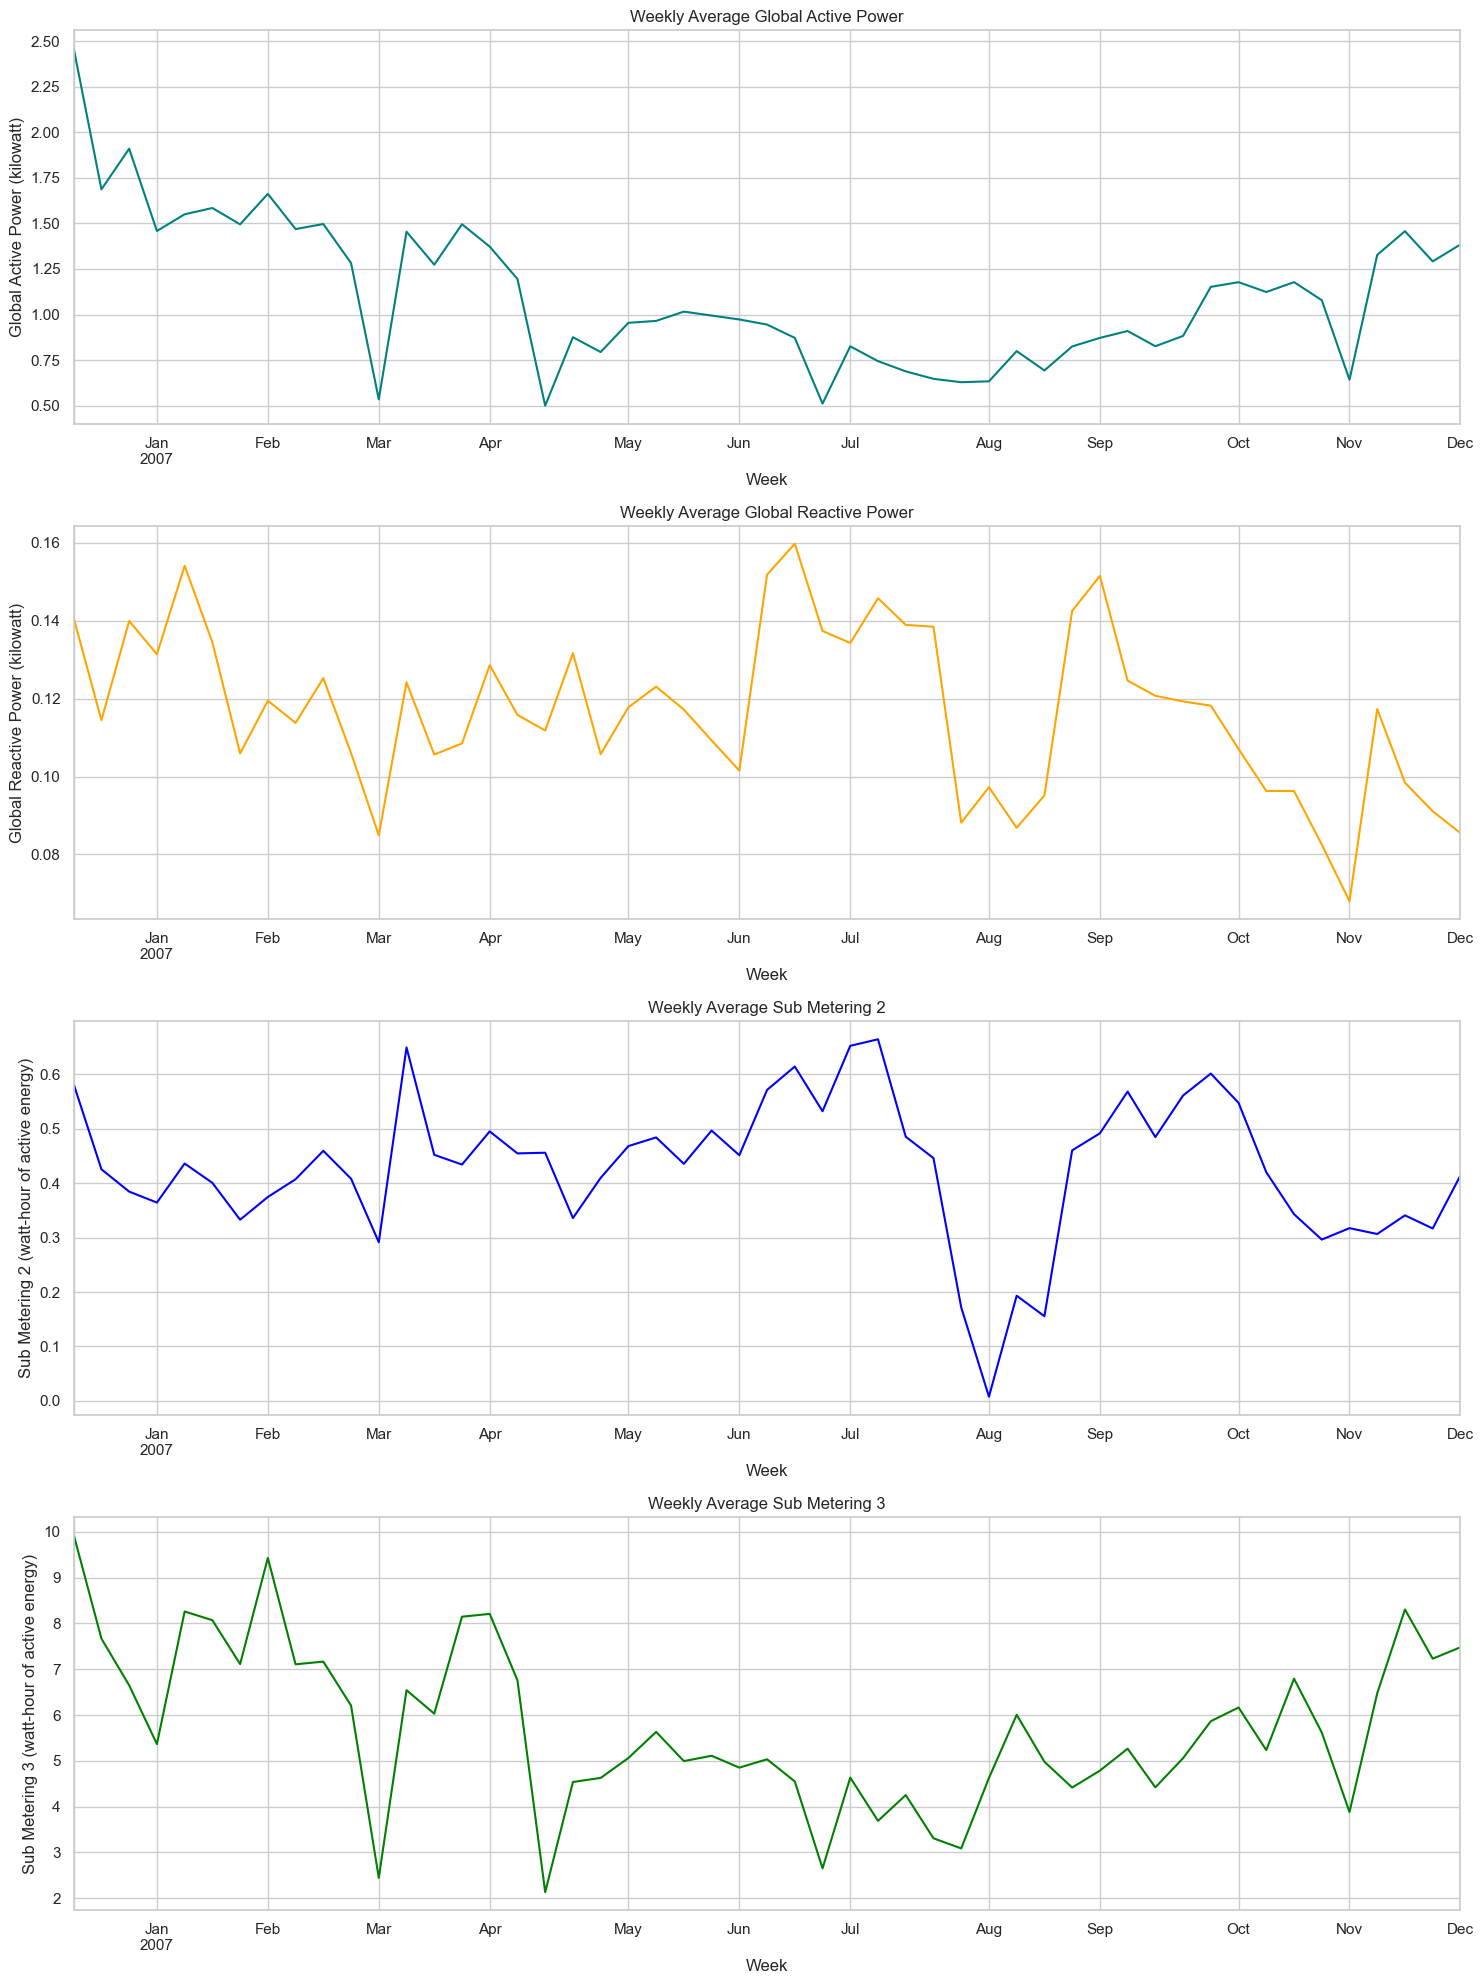

In [15]:
# Resample to weekly frequency and compute mean
weekly_data = dataset.resample("W").mean()

weekly_titles = [
    "Weekly Average Global Active Power",
    "Weekly Average Global Reactive Power",
    "Weekly Average Sub Metering 2",
    "Weekly Average Sub Metering 3",
]

# Plotting weekly aggregated data in a single figure with subplots
plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

for i, (col, color, title, ylabel) in enumerate(
    zip(columns_to_plot, colors, weekly_titles, y_labels), 1
):
    plt.subplot(len(columns_to_plot), 1, i)
    weekly_data[col].plot(color=color)
    plt.title(title)
    plt.xlabel("Week")
    plt.ylabel(ylabel)

plt.tight_layout()  
plt.show()


##### Analysis of Weekly Energy Consumption Patterns

1. **Global Active Power (Weekly):**
   - **High Consumption Weeks:** 
     - Winter weeks (December-February): 2.5-3.0 kW
     - Early spring weeks: 2.0-2.5 kW
   - **Low Consumption Weeks:**
     - Summer weeks (July-August): 0.8-1.2 kW
     - Late spring weeks: 1.2-1.5 kW
   - **Weekly Patterns:**
     - Higher consumption during working weeks
     - Lower consumption during holiday weeks
   - **Transition Periods:** Gradual changes between seasons

2. **Global Reactive Power (Weekly):**
   - **Peak Weeks:** 
     - Mid-January weeks: 0.16-0.20 kW
     - Early September weeks: 0.18-0.21 kW
   - **Low Usage Weeks:**
     - Late July weeks: 0.06-0.08 kW
     - Mid-August weeks: 0.07-0.09 kW
   - **Weekly Variations:** More pronounced during seasonal transitions
   - **Stable Periods:** Mid-spring weeks show consistent patterns

3. **Sub Metering 1 (Weekly):**
   - **Overall Trend:** Consistently low usage around 0.00 watt-hours
   - **Weekly Fluctuations:** Minimal to none
   - **Seasonal Impact:** No significant weekly variations across seasons

4. **Sub Metering 2 (Weekly):**
   - **High Usage Weeks:**
     - March weeks: 0.8-1.0 watt-hours
     - June weeks: 0.9-1.0 watt-hours
   - **Low Usage Weeks:**
     - August weeks: 0.0-0.2 watt-hours
     - Late July weeks: 0.1-0.3 watt-hours
   - **Weekly Pattern:** More variable during transition seasons
   - **Average Usage:** 0.4-0.6 watt-hours during typical weeks

5. **Sub Metering 3 (Weekly):**
   - **Peak Consumption Weeks:**
     - Mid-winter weeks: 10-12 watt-hours
     - Early December weeks: 8-10 watt-hours
   - **Low Consumption Weeks:**
     - Mid-summer weeks: 2-4 watt-hours
     - Late August weeks: 3-5 watt-hours
   - **Weekly Variations:** Most volatile among all metrics
   - **Seasonal Pattern:** Clear weekly trends following seasonal changes

### Feature Engineering

Based on our EDA, the most impactful temporal patterns were:

**Essential Features to Extract:**
   - `is_weekend` (0/1): Clear weekday vs weekend differences
   - `hour` (0-23): Daily consumption patterns


In [16]:
# # 1. Create basic time features
# dataset['is_weekend'] = dataset.index.dayofweek.isin([5, 6]).astype(int)
# dataset['hour'] = dataset.index.hour
# dataset.head()

### Correlation Analysis

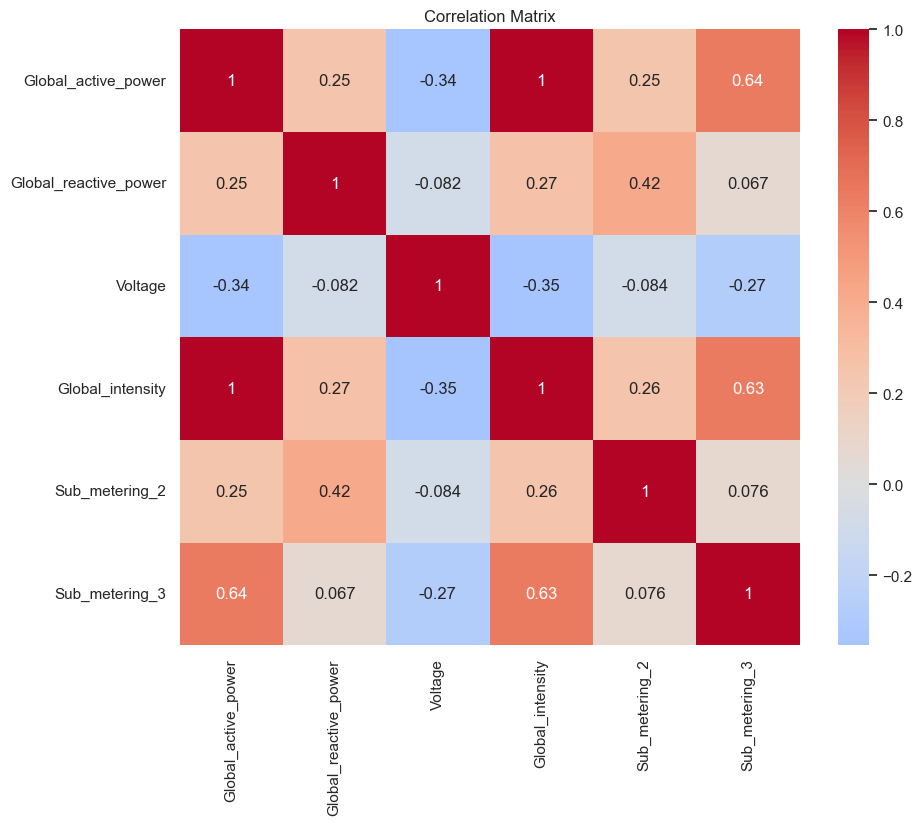

In [17]:
# Calculate the correlation matrix
correlation_matrix = dataset[numerical_cols].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#### Scale or normalize numerical features.

In [18]:
# Identify numerical features that need scaling
numerical_features = numerical_cols.copy()
numerical_features.remove("Global_active_power")
numerical_features.remove("Global_intensity")
# numerical_features.append("hour")
numerical_features


['Global_reactive_power', 'Voltage', 'Sub_metering_2', 'Sub_metering_3']

In [19]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform numerical features
dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

# Verify the scaling
print("\nAfter scaling - Mean and Standard Deviation:")
dataset[numerical_features].describe().loc[['mean', 'std']]


After scaling - Mean and Standard Deviation:


,Global_reactive_power,Voltage,Sub_metering_2,Sub_metering_3
mean,1.223802e-16,-1.233427e-14,-2.704281e-17,1.446103e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00


### Data Splitting

In [20]:
# Split data into training, validation, and test sets.

# Prepare features (X) and target variable (y)
# Features we engineered + relevant numerical features from EDA
features = dataset.columns.to_list()
features.remove("Global_active_power")
features.remove("Global_intensity")

X = dataset[features]
Y = dataset['Global_active_power']

# Since this is time series data, we'll split chronologically
# Use 60% for training, 20% for validation, 20% for testing
train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)

# Training set: first 60%
X_train = X[:train_size]
y_train = Y[:train_size]

# Validation set: next 20%
X_val = X[train_size:train_size + val_size]
y_val = Y[train_size:train_size + val_size]

# Test set: last 20%
X_test = X[train_size + val_size:]
y_test = Y[train_size + val_size:]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

print("\nDate ranges:")
print("Training:", X_train.index[0], "to", X_train.index[-1])
print("Validation:", X_val.index[0], "to", X_val.index[-1])
print("Test:", X_test.index[0], "to", X_test.index[-1])

Training set shape: (297640, 4)
Validation set shape: (99213, 4)
Test set shape: (99214, 4)

Date ranges:
Training: 2006-12-16 17:24:00 to 2007-07-14 00:58:00
Validation: 2007-07-14 00:59:00 to 2007-09-21 01:04:00
Test: 2007-09-21 01:05:00 to 2007-11-28 22:43:00


In [21]:
features

['Global_reactive_power', 'Voltage', 'Sub_metering_2', 'Sub_metering_3']

### Model Selection, Development, and Training

In [22]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    # 'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    val_predictions = model.predict(X_val)
    
    # Evaluate the model
    rmse, mae, r2 = evaluate_model(y_val, val_predictions, name)
    
    # Store results
    results[name] = {
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Find the best model based on RMSE
best_model_name = min(results.keys(), key=lambda k: results[k]['rmse'])
print(f"\nBest performing model: {best_model_name}")


Training Linear Regression...

Linear Regression Performance:
RMSE: 0.7033
MAE: 0.5953
R2 Score: 0.3697

Training Random Forest...

Random Forest Performance:
RMSE: 0.8186
MAE: 0.5857
R2 Score: 0.1460

Best performing model: Linear Regression


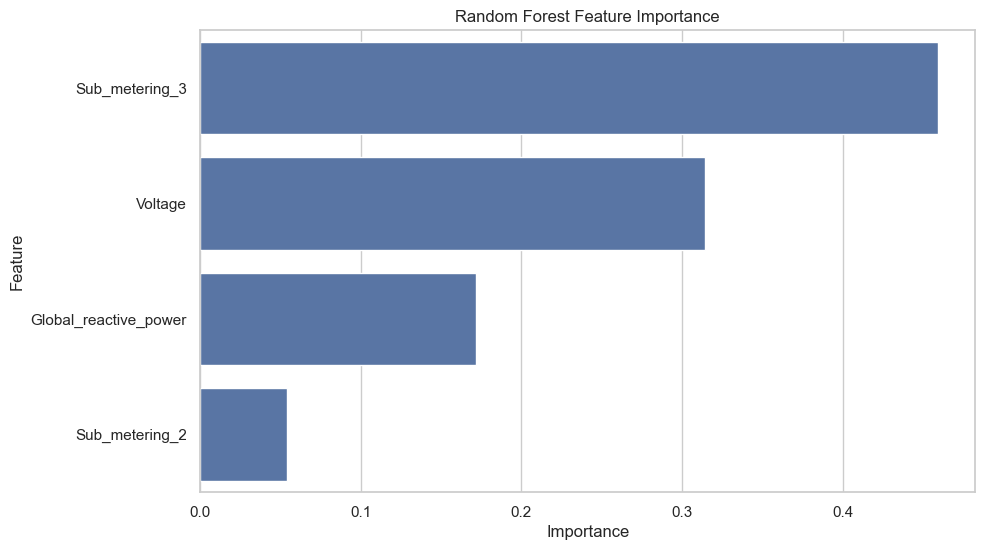


Feature Importance:
                 feature  importance
3         Sub_metering_3    0.459465
1                Voltage    0.314578
0  Global_reactive_power    0.171823
2         Sub_metering_2    0.054133


In [23]:
# Get feature importance from Random Forest model
rf_model = results["Random Forest"]["model"]
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf_model.feature_importances_}
)

# Sort features by importance
feature_importance = feature_importance.sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Print feature importance
print("\nFeature Importance:")
print(feature_importance)

#### Model Evaluation


In [24]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}


# Initialize Random Forest for grid search
rf_grid = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="neg_root_mean_squared_error",
)

# Fit grid search
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Evaluate best model on validation set
best_rf = grid_search.best_estimator_
val_predictions = best_rf.predict(X_val)
print("\nBest Model Performance on Validation Set:")
evaluate_model(y_val, val_predictions, "Optimized Random Forest")

# Compare with original Random Forest performance
print("\nOriginal Random Forest Performance:")
print(f"RMSE: {results['Random Forest']['rmse']:.4f}")
print(f"MAE: {results['Random Forest']['mae']:.4f}")
print(f"R2 Score: {results['Random Forest']['r2']:.4f}")

Starting Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE: 0.8547308368088076

Best Model Performance on Validation Set:

Optimized Random Forest Performance:
RMSE: 0.6775
MAE: 0.5315
R2 Score: 0.4151

Original Random Forest Performance:
RMSE: 0.8186
MAE: 0.5857
R2 Score: 0.1460


### Model Testing

Final Model Performance on Test Set:

Optimized Random Forest Performance:
RMSE: 0.7163
MAE: 0.5092
R2 Score: 0.5697


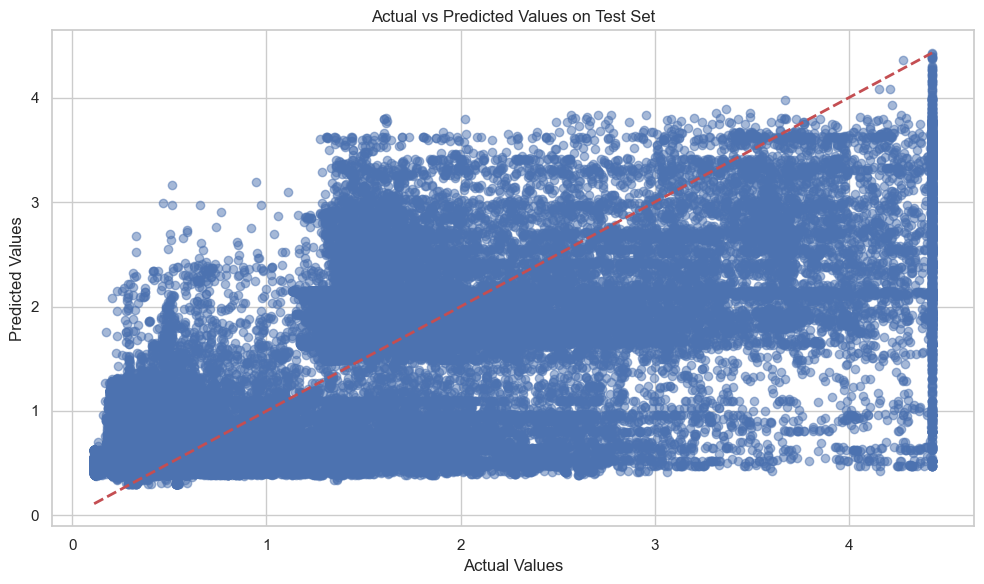

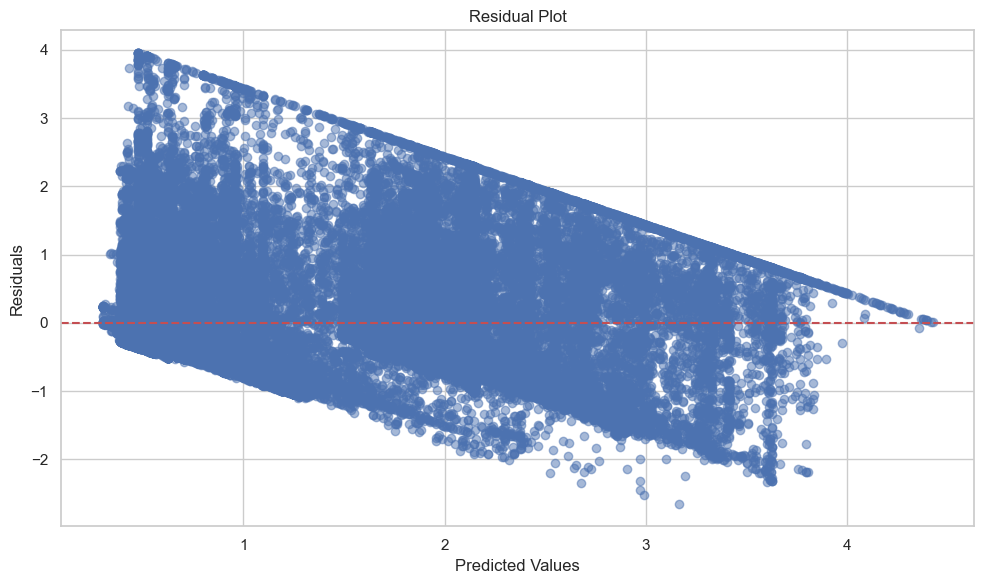


Model Performance Summary:
Test RMSE: 0.7163
Test MAE: 0.5092
Test R² Score: 0.5697

Best Model Parameters:
max_depth: 10
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 100


In [26]:
# Evaluate best model on test set
test_predictions = best_rf.predict(X_test)
print("Final Model Performance on Test Set:")
test_rmse, test_mae, test_r2 = evaluate_model(y_test, test_predictions, "Optimized Random Forest")

# Create visualization of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - test_predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Print summary of model performance
print("\nModel Performance Summary:")
print("==========================")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print("\nBest Model Parameters:")
print("======================")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

### Save Model

In [27]:
# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('models/energy_consumption'):
    os.makedirs('models/energy_consumption')

# Save the scaler
scaler_filename = "models/energy_consumption/standard_scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Save the best Random Forest model
model_filename = "models/energy_consumption/random_forest_model.pkl"
joblib.dump(best_rf, model_filename)

print(f"Scaler saved to: {scaler_filename}")
print(f"Model saved to: {model_filename}")

# Verify we can load them back
loaded_scaler = joblib.load(scaler_filename)
loaded_model = joblib.load(model_filename)

# Test prediction with loaded model
sample_prediction_original = best_rf.predict(X_test[:1])
sample_prediction_loaded = loaded_model.predict(X_test[:1])
print("\nSample prediction comparison:")
print("Original model prediction:", sample_prediction_original)
print("Loaded model prediction:", sample_prediction_loaded)

Scaler saved to: models/energy_consumption/standard_scaler.pkl
Model saved to: models/energy_consumption/random_forest_model.pkl

Sample prediction comparison:
Original model prediction: [0.61562623]
Loaded model prediction: [0.61562623]
